## Import bibliotek

In [12]:
%pip install sentence_transformers
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Note: you may need to restart the kernel to use updated packages.


## Załadowanie żartów z bazy

In [28]:
# Load ratings for jokes
df = pd.read_csv("ratings.csv")
df = df.iloc[: , 1:26]

mean_ratings = df[df != 99].mean().values

# Print the mean ratings array
print(mean_ratings)

# Load jokes
jokes = []
add = False
# Using readlines()
for i in range(1, 26):
    file1 = open(f"jokes/init{i}.html", 'r')
    Lines = file1.readlines()
    joke = ""
    # Strips the newline character
    for line in Lines:
        if line.startswith("<!--begin of joke -->"):
            add = True
        elif line.startswith("<!--end of joke -->"):
            add = False
        elif line == "" or line.startswith("<"):
            continue
        elif add:
            line = line.split("<")[0]
            joke+=line
    jokes.append(joke)

[ 0.9045733   0.20845963  0.31657433 -1.44911392  0.40355647  1.59444716
 -0.42966248 -0.6240851  -0.55703085  1.30123056  1.80579671  1.44929001
 -1.76288179  1.39633444 -1.70620131 -3.10481802 -1.11514131 -0.63510349
  0.15422692 -0.9339968   2.09562578  0.86866188  0.10919233 -1.68741986
  0.38237269]


## Ekstrakcja cech

In [29]:
model = SentenceTransformer('bert-base-cased')

embeddings = model.encode(jokes)

embeddings.shape

X = embeddings
Y = mean_ratings

No sentence-transformers model found with name C:\Users\wdomi/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\wdomi/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

## Podział danych na zbiór uczący i walidacyjny

In [30]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

## Funkcja pomocnicza do trenowania modelu i wizualizacji 

In [31]:
def test_model(X_train, X_val, Y_train, Y_val, epochs=1000, solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=0.001, hidden_layer_sizes=(100,)):
    model = MLPRegressor(solver=solver, alpha=alpha, learning_rate=learning_rate, learning_rate_init=learning_rate_init, hidden_layer_sizes=hidden_layer_sizes)

    # Train model
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        model.partial_fit(X_train, Y_train)
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)
        train_loss.append(mean_squared_error(Y_train, train_predictions))
        val_loss.append(mean_squared_error(Y_val, val_predictions))
        
    # Plotting
    plt.plot(range(1, epochs+1), train_loss, label='Zbiór uczący')
    plt.plot(range(1, epochs+1), val_loss, label='Zbiór walidacyjny')
    plt.xlabel('Liczba epok')
    plt.ylabel('Bląd średniokwadratory')
    plt.title('Model')
    plt.legend()
    plt.show()

## Test modelu dla domyślnej konfiguracji hiperparametrów

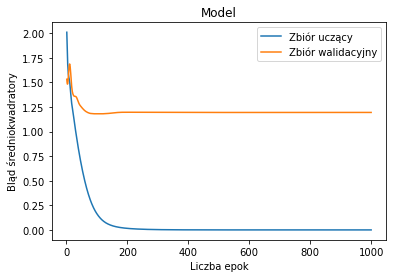

In [32]:
test_model(X_train, X_val, Y_train, Y_val)

Model bardzo szybko uczy się danych ze zbioru uczącego (błąd średniokwadratowy szybko spada do zera), zaś dla danych walidacyjnych radzi sobie gorzej - najprawdopodobniej wystapiło tutaj zjawisko "overfittingu", czyli nadmiernego dopasowania modelu do danych, na których się uczył.

## Wpływ tempa uczenia na wyniki

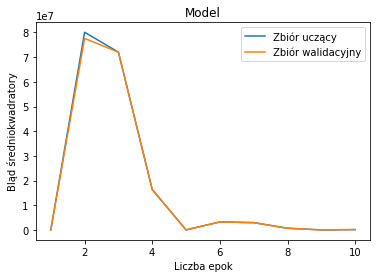

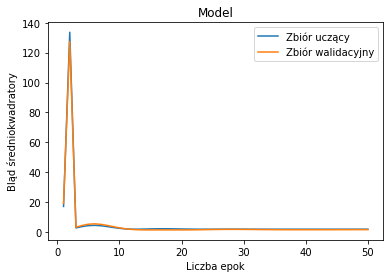

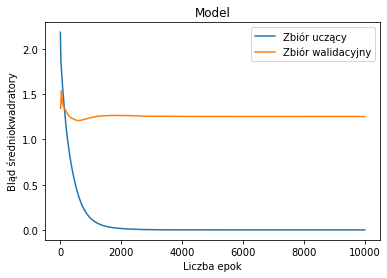

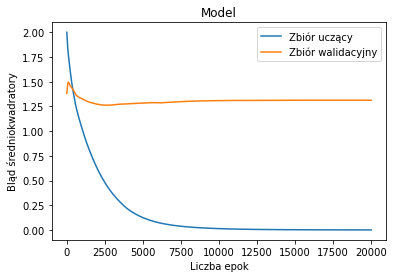

In [34]:
test_model(X_train, X_val, Y_train, Y_val, learning_rate_init=0.5, epochs=10)
test_model(X_train, X_val, Y_train, Y_val, learning_rate_init=0.08, epochs=50)
test_model(X_train, X_val, Y_train, Y_val, learning_rate_init=0.0001, epochs=10000)
test_model(X_train, X_val, Y_train, Y_val, learning_rate_init=0.00002, epochs=20000)

Widzimy, że dla zbyt dużego parametru "learning_rate_init" (powyżej domyślnego 0.001) błąd spada bardzo szybko - spada wartość funkcji kosztu, co skutkuje szybką aktualizacją wag. Model oscyluje wokół minimum funkcji kosztu, co uniemożliwia znalezienie optymalnych wag. Model potrzebuje zatem więcej iteracji, aby osiągnąć zbieżność. Zaś dla zbyt małej wartości parametru występują bardzo małe kroki aktualizacji wag na podstawie gradientów, co powoduje znaczne wydłużenie czasu uczenia (konieczne było duże zwiększenie liczby epok). Zbyt małe "learning_rate_init" powoduje prawdopodobnie utykanie w minimach lokalnych funkcji kosztu, uniemożliwiając modelowi dotarcie do bardziej optymalnych rozwiązań. Przez zbyt małe kroki uczenia model może "zawiesić się" w minimach lokalnych i nie będzie miał wystarczającej elastyczności do eksplorowania przestrzeni parametrów - występuje zjawisko "overfittingu", czyli nadmiernego dopasowania modelu do danych.

## Wpływ rozmiaru modelu na wyniki

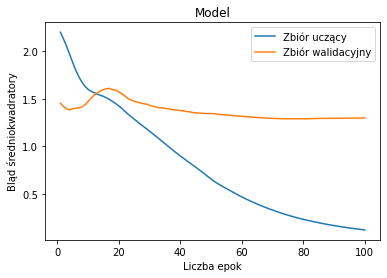

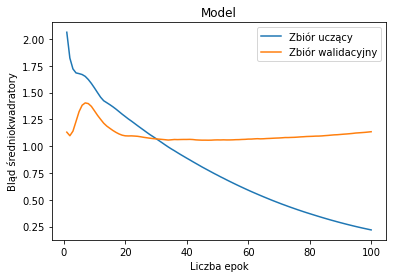

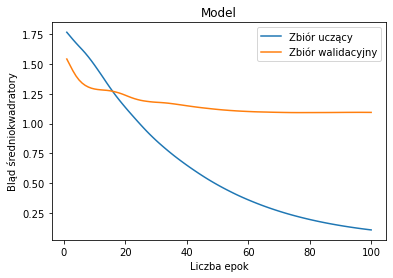

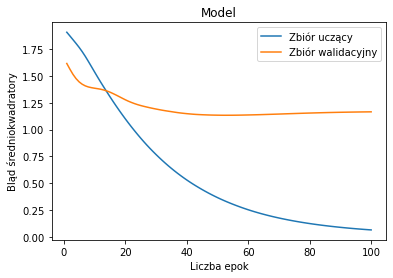

In [35]:
test_model(X_train, X_val, Y_train, Y_val, hidden_layer_sizes=(5,), epochs=100)
test_model(X_train, X_val, Y_train, Y_val, hidden_layer_sizes=(20,), epochs=100)
test_model(X_train, X_val, Y_train, Y_val, hidden_layer_sizes=(200,), epochs=100)
test_model(X_train, X_val, Y_train, Y_val, hidden_layer_sizes=(1000,), epochs=100)

Dla zbyt małych liczb neuronów w sieci model ma trudności z dopasowaniem się do danych treningowych oraz skutecznym przewidywaniem wartości testowych. Występuje tu zjawisko "underfittingu" - model nie jest w stanie uchwycić wystarczająco dużo informacji, aby dokładnie prognozować wartości docelowe. Dla wartości bliskich domyślnemu ustawieniu (50, 200) przejawia się powoli zjawisko "overfittingu" - model bardzo skutecznie uczy się zbiioru treningowego, zaś dla danych testowych ma słabą skuteczność. Najbardziej widać to dla wartości dużo większych niż domyślne (tutaj: 1000) - najprawdopodobniej model, poprzez swoją nadmierną złożoność uczy się zależności, które nie są reprezentatywne dla rzeczywistych danych, lecz dopasowuje się do szumów czy nieistotnych wzorców w danych treningowych. 

## Testowanie modelu dla przykładowych żartów 

In [37]:
joke_1 = "What kind of keys are sweet? Cookies!"
joke_2 = "Why do Java Programmers have to wear glasses? Because they can't C#."

model = SentenceTransformer('bert-base-cased')

joke_embedding = model.encode([joke_1])
model = MLPRegressor(learning_rate_init=0.001, hidden_layer_sizes=200)
model.partial_fit(X_train, Y_train)
predicted_rating = model.predict(joke_embedding)

print(f"Ocena: {predicted_rating}")

No sentence-transformers model found with name C:\Users\wdomi/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\wdomi/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

Ocena: [-0.89159083]


Niestety, model ma inne poczucie humoru niż ja i nie potrafi docenić dobrych programistycznych żartów. Warto jednak zwrocić uwagę na to, że sieć została nauczona na dość małej liczbie żartów, przez co ma ograniczone możliwości jeśli chodzi o ocenę żartów o specyficznej tematyce.